# Fast Elite Non-dominated Sorting Genetic Algorithm (NSGA-II)

We implement the NSGA-II here using pure Python, for the purpose of demonstrating the implementation and the procedure.


In [1]:
from math import exp, sqrt
from random import random, randint, sample, uniform
import functools
import matplotlib.pyplot as plt

## Representation: define a solution class

We first define a class for each individual solution called `solution`. We use the binary representation here and it is necessary to specify the number of variables (`numvar`) and the length (in bits) of each variable (l). If the named variable `chrom` is None (default), the code will randomly generate the bits as the initial solution; otherwise, we will use whatever is passed by the user to set up the chromosome. The users should also set the bounds of each variable. The decoder and evaluator will be needed if the object of this class needs to be functional.

The member called `deltas` is used to decode a binary string. We will discuss this later when we talk about decoders.

We override a couple of crucial methods for multiobjective optimization by defining how solutions can be compared. These are in the methods of `__lt__` and `__gt__`. When we assume minimization, a solution p is better than q if p has at least one objective function value smaller than q's and all other objective function values are not greater than q's.

In [2]:
class solution():
    def __init__(self, numvar, l, chrom=None, bounds=None, decoder=None, evaluator=None):
        '''
        numvar - number of variables
        l - length (in bits) of each variable
        bounds - [ [lo, hi], [lo, hi], [lo, hi]...], length is n
        '''
        self.n = 0 # domination counter, the # of solutions that dominate this one
        self.distance = 0 
        self.fitness = 0
        self.numvar = numvar 
        self.l = l
        if not chrom:
            self.chromosome = ''.join(['1' if flip(0.5) else '0' for i in range(numvar*l)])
        else:
            self.chromosome = chrom
        if len(bounds) != numvar:
            raise Exception('Bounds must have the same length as n')
        if len(self.chromosome) != numvar*l:
            raise Exception('Lengh of chromosome error')
        self.decoder = decoder
        self.evaluator = evaluator
        self.obj = []
        self.bounds = bounds
        self.deltas = [] # used in decode to convert binary 
        for b in bounds:
            d = (b[1]-b[0]) / (2**l-1)
            self.deltas.append(d) # store delta
        # self.obj = evaluator(decoder(self.chromosome))
        
    def decode(self):
        if not self.evaluator:
            raise Exception('Evaluator not specified')
        return self.decoder(self.chromosome, self.numvar, self.l, self.bounds, self.deltas)
        
    def evaluate(self):
        if not self.evaluator:
            raise Exception('Evaluator not specified')
        self.obj = self.evaluator(self.decode())
    
    def __lt__(self, other): # return true if there is at least one < and others <= or <
        num_proper_smaller_than = 0
        for i in range(len(self.obj)):
            if self.obj[i] > other.obj[i]:
                return False
            if self.obj[i] < other.obj[i]:
                num_proper_smaller_than += 1
        return num_proper_smaller_than > 0

    def __gt__(self, other):
        num_proper_greater_than = 0
        for i in range(len(self.obj)):
            if self.obj[i] < other.obj[i]:
                return False
            if self.obj[i] > other.obj[i]:
                num_proper_greater_than += 1
        return num_proper_greater_than > 0
    
    def dominate(self, other, direction='minimize'): # return true if this object dominates the other
        if direction=='minimize':
            return self < other
        else:
            return self > other

## Fast non-dominated sorting (key algorithm)

The following is the key part of the entire algorithm for nondominated sorting. Here, a population of solutions (`P`) will be ranked due to the solutions non-domination within the population. The function returns a dictionary `F1` where the key are integers, each indicating the front where ranked 1 means a solution dominates all other solutions ranked above 1. After the function is run, each solution will have assigned a value of its `rank` member (1 being the highest/best) and an `n` member indicating the number of solutions that dominates it. The values in the returned dictionary are solution objects. Comments in the function without a dot are from the original paper. The values in F are integers (indexes) and the converted to objects at the end of the function.

In [3]:
def fast_non_domnated_sort(P): # P is a list of individual objects
    F = {1:[]}                        #. stores index in R (P and Q combined)
    S = {}
    for i in range(len(P)):
        p = P[i]
        S[i] = []
        p.n = 0
        for j in range(len(P)):
            q = P[j]
            if p < q:                 # If p dominates q (#. assuming minimization)
                S[i].append(j)        # Add q to the set of solutions dominated by p
            elif q < p:
                p.n += 1              # Increament the domination counter of p
        if p.n == 0:                  # p belongs to the first front
            p.rank = 1
            F[1].append(i)
    i = 1                             # Initialize the front counter
    while F[i] != []:
        Q = []                        # Used to store the members of the next front
        for pi in F[i]:
            for qi in S[pi]:
                P[qi].n -= 1
                if P[qi].n == 0:      # q belongs to the next front
                    P[qi].rank = i+1
                    Q.append(qi)
        i += 1
        F[i] = Q

    F1 = {}
    for f in F:
        F1[f] = [P[i] for i in F[f]]  #. change indexes to objects for return
    return F1


The following function computes the distance of each solution in the same rank. This is critical in differentiating the solutions with the same rank because in NSGA-II, the fitness value of each solution is simply its rank. There will be a lot solutions with the same fitness/rank and therefore it is necessary to further set them apart, especially when (1) we want to select between two solutions and (2) when we decide which solutions should be included in the next generation when only a subset of those of the same rank can be selected.

In [4]:
def crowding_distance_assignment(I):
    # I is a list of nondominated solutions
    l = len(I)
    if l == 0:
        return
    for m in range(len(I[0].obj)):
        # sort by obj m
        I.sort(key=lambda x: x.obj[m])
        I[0].distance = I[-1].distance = float('inf')
        fm_min = I[0].obj[m]
        fm_max = I[-1].obj[m]
        if fm_min == fm_max:
            for i in range(1, l-1):
                I[i].distance = 0
        else:
            for i in range(1, l-1):
                I[i].distance += (I[i+1].obj[m] - I[i-1].obj[m]) / (fm_max - fm_min)

The following function decides between two solutions which one is considered to be better. The benefit of the above function (i.e., calculating the distance of each solution in the objective space) is reflected here.

In [5]:
def crowded_comparison_operator(i, j):
    # i and j are two individual objects
    # i is BETTER than j if:
    #     i_rank < j_rank 
    #     or 
    #     i_rank = j_rank and i_distance > j_distance
    #
    if i.rank < j.rank:
        return 1
    if i.rank == j.rank and i.distance > j.distance:
        return 1
    if i.rank == j.rank and i.distance == j.distance:
        return 0
    return -1

## Functions for the genetic algorithms

Here we implement some generic functions for the GA. We use a tournament selection here.

In [6]:
def selection(population):
    # tournament
    # population is a list of individual objects
    i, j = sample(range(len(population)), 2)
    i, j = population[i], population[j]
    comp = crowded_comparison_operator(i, j)
    if comp > 0:
        return i
    elif comp < 0:
        return j
    else:
        return i # i and j doesn't matter



A single point crossover method is used here. The mutation function uses a probability to decide whether a bit should be flipped.

In [7]:
def recombination(i, j, p):
    c1 = i.chromosome
    c2 = j.chromosome
    if not flip(p):
        return
    point = randint(0, i.numvar*i.l-1)
    c1 = i.chromosome[:point] + j.chromosome[point:]
    c2 = j.chromosome[:point] + i.chromosome[point:]
    i1 = solution(i.numvar, i.l, c1, i.bounds, i.decoder, i.evaluator)
    j1 = solution(i.numvar, i.l, c2, i.bounds, i.decoder, i.evaluator)
    return i1, j1

def flip(prob):
    if random() < prob:
        return True
    return False

def mutation(i, p):
    # reverse_chars = ['1', '0']
    # chrom = ''.join([c if not flip(p) else reverse_chars[int(c)] for c in i.chromosome])
    chrom = ''.join([c if not flip(p) else str(1-int(c)) for c in i.chromosome])
    i.chromosome = chrom


Finally, here is the procedure to generate a population.

In [8]:
def make_new_pop(P, crossover_prob, mutation_prob):
    Q = []
    while len(Q) < len(P):
        i = selection(P)
        j = selection(P)
        recomb = recombination(i, j, crossover_prob)
        if recomb: # not None
            i1, j1 = recomb
            mutation(i1, mutation_prob)
            mutation(j1, mutation_prob)
            i1.evaluate()
            j1.evaluate()
            Q.append(i1)
            Q.append(j1)
    return Q

## Main workflow

<!-- 
Initially, a random parent population $P_0$ is created. The population is sorted based on the non-domination. Each solution is assigned a fitness equal to its non-domination level (1 is the best level). Thus, minimization of fitness is assumed. Binary tournament selection, recombination, and mutation operators are used to create a child population $Q_0$ of size $N$. From the first generation onward, the procedure is different. The elitism
procedure for $t \ge 1$ and for a particular generation is shown in the following:

$R_t = P_t \cup Q_t$  
$F = \text{fast-nondominated-sort}(R_t)$  
$\text{until } |P_{t+1}| < N$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\text{crowding-distance-assignment}(F_i)$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $P_{t+1} = P_{t+1} \cup F_i$  
$\text{sort}(P_{t+1, \ge n})$  
$P_{t+1} = P_{t+1}[0:N]$  
$Q_{t+1} = \text{make-new-pop}(P_{t+1})$

First, a combined population $R_t = P_t \cup Q_t$ is formed. The population $R_t$ will be of size $2N$. Then, the population $R_t$ is sorted according to non-domination. The new parent population $P_{t+1}$ is formed by adding solutions from the first front till the size exceeds $N$. Thereafter, the solutions of the last accepted front are sorted according to $\ge_n$ and the first $N$ points are picked. This is how we construct the population $P_{t+1}$ of size $N$. This population of size $N$ is now used for selection, crossover and mutation to create a new population $Q_{t+1}$ of size $N$. It is important to note that we use a binary tournament selection operator but the selection criterion is now based on the niched comparison operator $\ge_n$.
 -->

In [9]:
def nsga2_x(N, T, crossover_prob, mutation_prob, numvar, varlen, bounds, decoder, evaluator):
    '''
    N - population size
    T - number of generations
    bounds
    decoder
    evaluator
    '''
    R = {}
    P = {}
    Q = {}

    # created P0 randomly
    t = 0
    P[t] = [solution(numvar, varlen, bounds=bounds, decoder=decoder, evaluator=evaluator) for _ in range(N)] # evaluate by default?
    for i in P[t]:
        i.evaluate()

    fast_non_domnated_sort(P[t]) # need the fitness/rank for tournament selection

    Q[t] = make_new_pop(P[t], crossover_prob, mutation_prob)

    # main loop
    while t <= T:
        R[t] = P[t] + Q[t]
        F = fast_non_domnated_sort(R[t])
        P[t+1] = []
        i = 1
        while len(P[t+1])+len(F[i]) <= N:
            crowding_distance_assignment(F[i])
            P[t+1] = P[t+1] + F[i]
            i += 1
        # i is not the front that hasn't been included
        # will need some solutions from it if the previous loop hasn't got N solutions
        # F[i] is not assigned fitness/rank yet (overlooked in original paper)
        
        crowding_distance_assignment(F[i]) # NOTE: this step is missed in the original paper!
        F[i].sort(key=functools.cmp_to_key(crowded_comparison_operator), reverse=True) 
        P[t+1] = P[t+1] + F[i][:N-len(P[t+1])]
        Q[t+1] = make_new_pop(P[t+1], crossover_prob, mutation_prob)
        t += 1
    return P

## Doodle

We now make some random experiments to try out some of the functions above. To start with, it is important to have a decoder and an evaluator. We are going to use a very simple problem with 1 variable and two objectives. This is the problem called SCH in the original paper by Deb et al. The two objective functions are defined as:

$f_1(x) = x^2$  
$f_2(x) = (x-2)^2$

where $x \in [-10^3, 10^3]$.

### Decoder

Suppose we use a binary string to represent the variable. Giving a binary string $x'$, we can convert that to a decimal value, which will be ranging from 0 to $2^l$ where $l$ is the length of the binary string. We then need to scale this decimal value using the bounds of the variable:

$x = x_{\text{min}} + \text{decimal}(x') (x_{\text{max}} - x_{\text{min}}) / (2^l - 1)$

where $x_{\text{min}}$ and $x_{\text{min}}$ are the lower and upper bounds of the variable, respectively, $\text{decimal}$ is a function that converts a binary string to a decimal, and $l$ is the length of the binary string. We calculate the constant part of the second term as a valuate of `deltas` in the `__init__` method of the solution class.

Our decoder function is going to look like this:

In [10]:
def decoder(chrom, numvar, l, bounds, deltas):
    vars = []
    for i in range(numvar):
        var = bounds[i][0] + int(chrom[i*l:(i+1)*l], 2)*deltas[i]
        vars.append(var)
    return vars

It should be noted that the above decoder is quite generic and can be applied to many problems, as long as the parameters of the function are specified correctly for the problem.

### Evaluator

The evaluator must be specifically defined for each problem. In our experiments here, we define it as follows:

In [11]:
def evaluator(vars):
    # need 1 variable
    x = vars[0]
    f1 = x**2
    f2 = (x-2)**2
    return [f1, f2]

### Some quick experiments

Now, we define the following two parameters to specify that there is only 1 variable and the length of the binary is 10:

In [12]:
numvar = 1
varlen = 10

We also specify the probability for crossover and mutation. For the mutation probability, we want in average each string has 1 bit being flipped:

In [13]:
crossover_prob = 0.9
mutation_prob = 1/numvar/varlen

The last thing will be the bounds:

In [14]:
bounds = [[-4, 4]]

With all the parameters set, the following is a quick way to create 2 objects of the solution class:

In [15]:
i = solution(numvar, varlen, bounds=bounds, decoder=decoder, evaluator=evaluator)
j = solution(numvar, varlen, bounds=bounds, decoder=decoder, evaluator=evaluator)

In [16]:
print(i.chromosome)
print(j.chromosome)

1100001011
1001010001


We can recombine them into two new ones:

In [17]:
i1, j1 = recombination(i, j, crossover_prob)

print(i1.chromosome)
print(j1.chromosome)

1100001011
1001010001


We can also check the results of mutation:

In [18]:
print(i.chromosome)
mutation(i, mutation_prob)
print(i.chromosome)
print(j.chromosome)
mutation(j, mutation_prob)
print(j.chromosome)

1100001011
1000001011
1001010001
1101010001


In [19]:
i = solution(numvar, varlen, bounds=bounds, decoder=decoder, evaluator=evaluator)
i.evaluate()
i.chromosome, i.decode(), i.obj, i.deltas

('1111101100',
 [3.8514173998044967],
 [14.83341598751683, 3.4277463882988437],
 [0.007820136852394917])

The decode method in the class can be used separately:

In [20]:
i.decode()

[3.8514173998044967]

We can manually run the first generation:

In [21]:
N = 100 # population size
t = 0
R = {}
P = {}
Q = {}

# created P0 randomly
P[t] = [solution(numvar, varlen, bounds=bounds, decoder=decoder, evaluator=evaluator) for _ in range(N)]
for i in P[t]:
    i.evaluate()
    
fast_non_domnated_sort(P[t])

Q[t] = make_new_pop(P[t], crossover_prob, mutation_prob)

In [22]:
selection(P[0])

In [23]:
i = P[0][0]
j = P[0][15]
crowded_comparison_operator(i, j)

-1

This should help us understand why the above code yields its output:

In [24]:
i.obj, j.obj

([8.125007524875087, 23.526767055666877],
 [0.2544181766582675, 6.272013484576156])

We can run the following several times to see how the population evaluates:

In [25]:
# main loop

R[t] = P[t] + Q[t]
F = fast_non_domnated_sort(R[t])
P[t+1] = []
i = 1
while len(P[t+1])+len(F[i]) <= N:
    crowding_distance_assignment(F[i])
    P[t+1] = P[t+1] + F[i]
    i += 1

# i is the index of the last fron to be included
# only need to sort the last front included in P[t+1] since we may have more than needed in F[i]
# sort F[i] , <n, 
F[i].sort(key=functools.cmp_to_key(crowded_comparison_operator), reverse=True) # comp func needs access to R and t

P[t+1] = P[t+1] + F[i][1:N-len(P[t+1])+1]
Q[t+1] = make_new_pop(P[t+1], crossover_prob, mutation_prob)

t += 1


In [26]:
t, len(P[t])

(1, 100)

In [27]:
len([p.rank for p in P[t] if p.rank==1])

61

Sometimes it helps to "see" the solution space before we run the GA. We can simply utilize the initialization function to generate a lot of random solutions and plot the solution space.

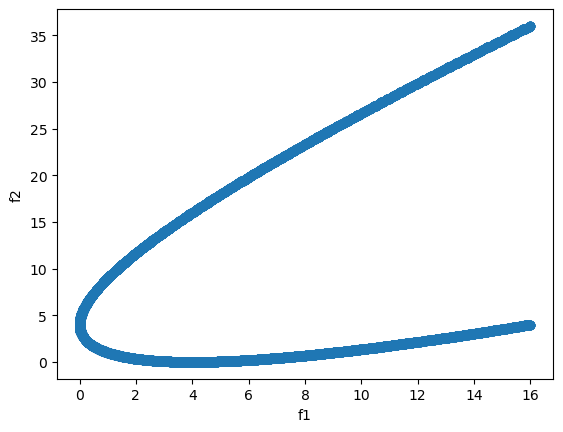

In [28]:
P_random = [solution(numvar, varlen, bounds=bounds, decoder=decoder, evaluator=evaluator) for _ in range(10000)]
for i in P_random:
    i.evaluate()

x1 = [(p.obj[0], p.obj[1]) for p in P_random]
x1.sort()
plt.plot([i[0] for i in x1], [i[1] for i in x1], 'o')

# plt.gca().set_aspect(1)
plt.xlabel('f1')
plt.ylabel('f2')
plt.show()

## Case study

We test the workflow presented above using a few examples. These are from the original paper by Deb et al.


### FON

$f_1(x) = 1 - \exp(-\sum_{i=1}^3(x_i - \frac{1}{\sqrt{3}})^2)$

$f_2(x) = 1 - \exp(-\sum_{i=1}^3(x_i + \frac{1}{\sqrt{3}})^2)$

where $x_i \in [-4, 4], i \in \{1, 2, 3\}$

In [39]:
# To decode, we use var = lo + decimal(chrom) * (hi - lo) / (2^l - 1), 
# where lo, hi, and l are the lower bound, upper bound, and length of binary string
# Because (hi-lo)/(2^l-1) is a constant, we get it in init, and name it as delta
#
def decoder(chrom, numvar, l, bounds, deltas):
    vars = []
    for i in range(numvar):
        var = bounds[i][0] + int(chrom[i*l:(i+1)*l], 2)*deltas[i]
        vars.append(var)
    return vars


# calculate objective functions values only
def evaluator(vars):
    # need three variables
    s1 = s2 = 0
    sqrt_3 = sqrt(3)
    for i in range(len(vars)):
        s1 += (vars[i] - 1/sqrt_3)**2
        s2 += (vars[i] + 1/sqrt_3)**2
    f1 = 1 - exp(-s1)
    f2 = 1 - exp(-s2)
    return [f1, f2]

In [40]:
N = 100
T = 100
bounds = [[-4, 4] for _ in range(3)]
numvar = 3
varlen = 10

crossover_prob = 0.9
mutation_prob = 0.1/numvar/varlen

P = nsga2_x(N, T, crossover_prob, mutation_prob, numvar, varlen, bounds, decoder, evaluator)

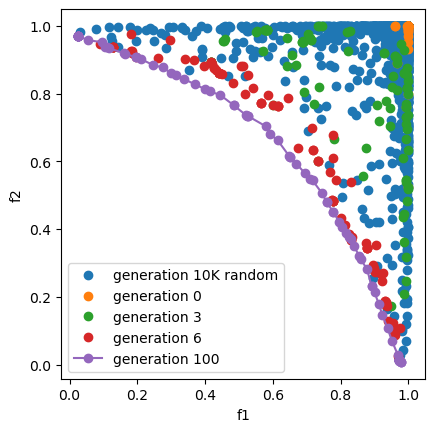

In [41]:
# generate a lot of random solutions and plot them
P['10K random'] = [solution(numvar, varlen, bounds=bounds, decoder=decoder, evaluator=evaluator) for _ in range(10000)]
for i in P['10K random']:
    i.evaluate()

toplot = ['10K random', 0, T//30, 2*T//30, T]
for i in toplot:
    x1 = [(p.obj[0], p.obj[1]) for p in P[i]]
    x1.sort()
    marker = 'o'
    if i == T:
        marker = 'o-'
    plt.plot([val[0] for val in x1], [val[1] for val in x1], marker, label=f'generation {i}')

plt.legend(loc='lower left')
plt.gca().set_aspect(1)
plt.xlabel('f1')
plt.ylabel('f2')
plt.show()

### POL

The two objective functions are:

$f_1(x) = 1 + (A_1 - B_1)^2 + (A_2 - B_2)^2$  
$f_2(x) = (x_1+3)^2 + (x_2+1)^2$

where $x_1$ and $x_2$ are the two decision variables with a range of $[-\pi, \pi]$. Other coefficients are defined below:

$A_1 = 0.5 \sin 1 - 2 \cos 1 + \sin 2 - 1.5 \cos 2$  
$A_2 = 1.5 \sin 1 - \cos 1 + 2 \sin 2 - 0.5 \cos 2$  
$B_1 = 0.5 \sin x_1 - 2 \cos x_1 + \sin x_2 - 1.5 \cos x_2$  
$B_2 = 1.5 \sin x_1 - \cos x_1 + 2 \sin x_2 - 0.5 \cos x_2$


In [42]:
from math import sin, cos

# calculate objective functions values only
def evaluator(vars):
    # need 2 variables
    x1, x2 = vars
    A1 = 0.5*sin(1) - 2*cos(1) + sin(2) - 1.5*cos(2)
    A2 = 1.5*sin(1) - cos(1) + 2*sin(2) - 0.5*cos(2)
    B1 = 0.5*sin(x1) - 2*cos(x1) + sin(x2) - 1.5*cos(x2)
    B2 = 1.5*sin(x1) - cos(x1) + 2*sin(x2) - 0.5*cos(x2)
    f1 = 1 + (A1-B1)**2 + (A2-B2)**2
    f2 = (x1+3)**2 + (x2+1)**2
    return [f1, f2]

In [43]:
from math import pi

N = 100
T = 100
bounds = [[-pi,pi], [-pi,pi]]
numvar = 2
varlen = 10

crossover_prob = 0.9
mutation_prob = 1/numvar/varlen

P = nsga2_x(N, T, crossover_prob, mutation_prob, numvar, varlen, bounds, decoder, evaluator)

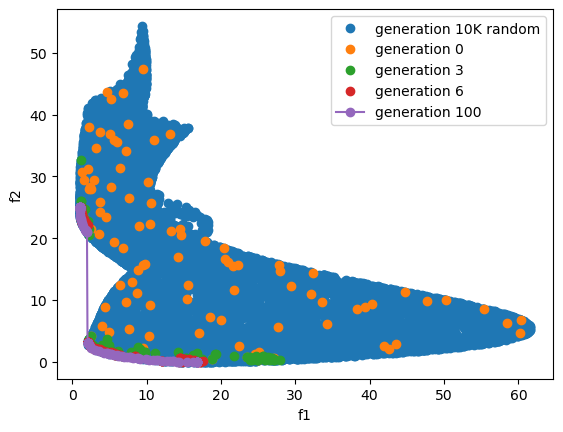

In [44]:
P['10K random'] = [solution(numvar, varlen, bounds=bounds, decoder=decoder, evaluator=evaluator) for _ in range(10000)]
for i in P['10K random']:
    i.evaluate()

toplot = ['10K random', 0, T//30, 2*T//30, T]
for i in toplot:
    x1 = [(p.obj[0], p.obj[1]) for p in P[i]]
    x1.sort()
    marker = 'o'
    if i == toplot[-1]:
        marker = 'o-'
    plt.plot([i[0] for i in x1], [i[1] for i in x1], marker, label=f'generation {i}')

plt.legend(loc='upper right')
# plt.gca().set_aspect(1)
plt.xlabel('f1')
plt.ylabel('f2')
plt.show()

### ZDT3

There are 30 decision variables for this problem. The two objective functions are:

$f_1(x) = x_1$  
$f_2(x) = g(x) [1-\sqrt{\frac{x_1}{g(x)}}-\frac{x_1}{g(x)}\sin(10 \pi x_1)]$  
$g(x) = 1 + 9 \frac{\sum_{i=2}^n x_i}{n-1}$

In [36]:
from math import sin, cos

# calculate objective functions values only
def evaluator(vars):
    # need 30 variables
    x1 = vars[0]
    f1 = x1
    g = 1 + 9 * sum(vars[1:]) / (len(vars)-1)
    f2 = g * (1-sqrt(x1/g)-x1/g*sin(10*pi*x1))
    return [f1, f2]

In [37]:
N = 100
T = 100
bounds = [[0, 1] for _ in range(30)]
numvar = 30
varlen = 10

crossover_prob = 0.9
mutation_prob = 1/numvar/varlen

P = nsga2_x(N, T, crossover_prob, mutation_prob, numvar, varlen, bounds, decoder, evaluator)

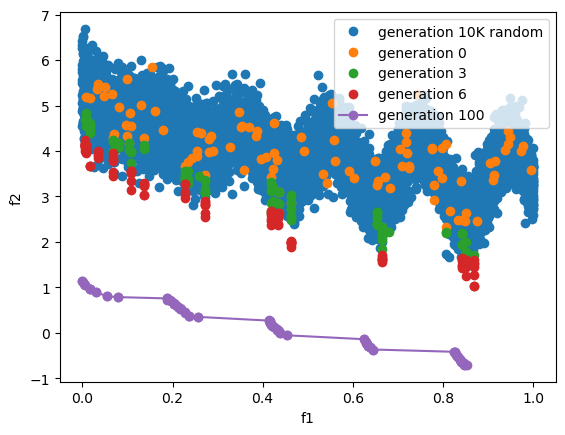

In [38]:
P['10K random'] = [solution(numvar, varlen, bounds=bounds, decoder=decoder, evaluator=evaluator) for _ in range(10000)]
for i in P['10K random']:
    i.evaluate()

toplot = ['10K random', 0, T//30, 2*T//30, T]
for i in toplot:
    x1 = [(p.obj[0], p.obj[1]) for p in P[i]]
    x1.sort()
    marker = 'o'
    if i == T:
        marker = 'o-'
    plt.plot([i[0] for i in x1], [i[1] for i in x1], marker, label=f'generation {i}')

plt.legend(loc='upper right')
# plt.gca().set_aspect(1)
plt.xlabel('f1')
plt.ylabel('f2')
plt.show()

## Summary

We have shown how to implement the non-dominated sorting algorithm (NSGA) and the binary coded genetic algorithm, and demonstrated how they can be used to solve a few example of multiobjective optimization problems. The visualizations of these application clearly suggest the effectiveness of both algorithms, where we can see how solutions in each generation move "across" the solution space from their random positions in the space toward the Pareto front that is optimal. 

The code for NSGA-II (along with the code for the binary coded GA) is stored in a separate Python module called nsga2.py and is ready to use. Here is a example of how to use it using the example problem called SCH (as used in the Doodle section):

```python
from nsga2 import *

def evaluator(vars):
    # need 1 variable
    x = vars[0]
    f1 = x**2
    f2 = (x-2)**2
    return [f1, f2]

N = 100
T = 10
numvar = 1
varlen = 10
bounds = [[-4, 4]]

crossover_prob = 0.9
mutation_prob = 1/numvar/varlen

P = nsga2_x(N, T, crossover_prob, mutation_prob, numvar, varlen, bounds, decoder, evaluator)


import matplotlib.pyplot as plt

P['10K random'] = [solution(numvar, varlen, bounds=bounds, decoder=decoder, evaluator=evaluator) for _ in range(10000)]
for i in P['10K random']:
    i.evaluate()

toplot = ['10K random', 0, T//30, 2*T//30, T]
for i in toplot:
    x1 = [(p.obj[0], p.obj[1]) for p in P[i]]
    x1.sort()
    marker = 'o'
    if i == toplot[-1]:
        marker = 'o-'
    plt.plot([i[0] for i in x1], [i[1] for i in x1], marker, label=f'generation {i}')

plt.xlabel('f1')
plt.ylabel('f2')
plt.legend(loc='upper left')
plt.show()
```